### We are normalizing from 0 to 1 without subtracting mean and dividing by std unlike other notebooks

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils import data as D
import os

In [2]:
from PIL import Image

In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [4]:
class Net(nn.Module):
    def __init__(self, features, num_classes, init_weights=True):
        super(Net, self).__init__()
        
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.ReLU(True),
            nn.Linear(500, num_classes)
        )
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        # x are the logits values
        return x 
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



In [5]:
"""
torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
"""

def make_layers(cfg, in_channels, kernel_size, stride, padding, batch_norm=False):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=kernel_size, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


"""
Refer VGG19_bn configurationh here: 
https://github.com/pytorch/vision/blob/76702a03d6cc2e4f431bfd1914d5e301c07bd489/torchvision/models/vgg.py#L63
"""
cfgs = {
    #'E': [64, 64, 'M',128, 128, 'M',256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',512, 512, 512, 512, 'M'],
    'E': [20, 'M', 50, 'M']
}

model_layers = make_layers(cfgs['E'],in_channels=1, kernel_size=5, stride=1, padding=0, batch_norm=False)

In [6]:
class CustomDS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path, train=True):
        """ Intialize the dataset
        """
        if train:
            data_path = os.path.join(path,'x_train.npy')
            targets_path = os.path.join(path,'y_train.npy')
        else:
            data_path = os.path.join(path,'x_test.npy')
            targets_path = os.path.join(path,'y_test.npy')

        self.path = data_path
        self.data = np.load(data_path)
        self.targets = np.load(targets_path)
        #self.transform = transforms.ToTensor()
        self.transform = transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])
        self.len = np.shape(self.data)[0]
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        data = self.data[index]
        image = Image.fromarray(data)
        
        target = int(self.targets[index])
        
        #data = (data * 255).astype(np.uint8)
        #data = data.reshape(28,28)
        #image = Image.fromarray((data * 255).astype(np.uint8))
        #image = Image.fromarray(data.astype(np.uint8))
        
        return self.transform(image), target

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [7]:
directory = './data/fmnist'

IS_DATA_READY = True
assert(IS_DATA_READY == True)

x_train = np.load(directory + '/x_train.npy')
y_train = np.load(directory + '/y_train.npy')
x_test = np.load(directory + '/x_test.npy')
y_test = np.load(directory + '/y_test.npy')
print('x_train shape : {}'.format(x_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))


# Simple dataset. Only save path to image and load it and transform to tensor when call __getitem__.
filepath = './data/fmnist/'
train_set = CustomDS(filepath, train=True)
test_set = CustomDS(filepath, train=False)

# total images in set
print(train_set.len)
print(test_set.len)

x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)
60000
10000


In [8]:
# main method
## Training settings
# input batch size for training (default: 64)
BATCH_SIZE = 50

# input batch size for testing (default: 1000)
TEST_BATCH_SIZE = 1

# number of epochs to train
EPOCHS = 10

#learning rate (default: 0.01)
LR = 0.01

#SGD momentum (default: 0.5)
MOMENTUM = 0.5

# how many batches to wait before logging training status
LOG_INTERVAL = 10

SAVE_MODEL = True
SEED = 1
NO_CUDA = False
USE_CUDA = not NO_CUDA and torch.cuda.is_available()

NUM_CLASSES=10

torch.manual_seed(SEED)

device = torch.device("cuda" if USE_CUDA else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}


In [9]:
# FMNIST Test dataset and dataloader declaration
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data/', train=False, download=True, 
#                    transform=transforms.Compose([transforms.ToTensor(),])),
#                    batch_size=1, shuffle=True)

train_loader = D.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
test_loader = D.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **kwargs)


# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # Initialize the network
# model = Net().to(device)

# # Load the pretrained model
# model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# # Set the model in evaluation mode. In this case this is for the Dropout layers
# model.eval()

pretrained_model = "model/fmnist/v2/fmnist_cnn.pt"
# Initialize the network
model = Net(model_layers, num_classes=NUM_CLASSES).cuda()

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


CUDA Available:  True


Net(
  (features): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [10]:
import torch
import operator as op
import functools as ft


'''reduce_* helper functions reduce tensors on all dimensions but the first.
They are intended to be used on batched tensors where dim 0 is the batch dim.
'''


def reduce_sum(x, keepdim=True):
    # silly PyTorch, when will you get proper reducing sums/means?
    for a in reversed(range(1, x.dim())):
        x = x.sum(a, keepdim=keepdim)
    return x


def reduce_mean(x, keepdim=True):
    numel = ft.reduce(op.mul, x.size()[1:])
    x = reduce_sum(x, keepdim=keepdim)
    return x / numel


def reduce_min(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.min(a, keepdim=keepdim)[0]
    return x


def reduce_max(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.max(a, keepdim=keepdim)[0]
    return x


def torch_arctanh(x, eps=1e-6):
    x *= (1. - eps)
    return (torch.log((1 + x) / (1 - x))) * 0.5


def l2r_dist(x, y, keepdim=True, eps=1e-8):
    d = (x - y)**2
    d = reduce_sum(d, keepdim=keepdim)
    d += eps  # to prevent infinite gradient at 0
    return d.sqrt()


def l2_dist(x, y, keepdim=True):
    d = (x - y)**2
    return reduce_sum(d, keepdim=keepdim)


def l1_dist(x, y, keepdim=True):
    d = torch.abs(x - y)
    return reduce_sum(d, keepdim=keepdim)


def l2_norm(x, keepdim=True):
    norm = reduce_sum(x*x, keepdim=keepdim)
    return norm.sqrt()


def l1_norm(x, keepdim=True):
    return reduce_sum(x.abs(), keepdim=keepdim)


def rescale(x, x_min=-1., x_max=1.):
    return x * (x_max - x_min) + x_min


def tanh_rescale(x, x_min=-1., x_max=1.):
    return (torch.tanh(x) + 1) * 0.5 * (x_max - x_min) + x_min

In [11]:
"""PyTorch Carlini and Wagner L2 attack algorithm.

Based on paper by Carlini & Wagner, https://arxiv.org/abs/1608.04644 and a reference implementation at
https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks_tf.py
"""
import os
import sys
import torch
import numpy as np
from torch import optim
from torch import autograd
#from .helpers import *


class AttackCarliniWagnerL2:

    def __init__(self, targeted=True, search_steps=None, max_steps=None, cuda=True, debug=False):
        self.debug = debug
        self.targeted = targeted
        #self.num_classes = 1000
        self.num_classes = 10
        self.confidence = 0  # FIXME need to find a good value for this, 0 value used in paper not doing much...
        self.initial_const = 0.1  # bumped up from default of .01 in reference code
        self.binary_search_steps = search_steps or 5
        self.repeat = self.binary_search_steps >= 10
        self.max_steps = max_steps or 1000
        self.abort_early = True
        self.clip_min = -1.
        self.clip_max = 1.
        self.cuda = cuda
        self.clamp_fn = 'tanh'  # set to something else perform a simple clamp instead of tanh
        self.init_rand = False  # an experiment, does a random starting point help?

    def _compare(self, output, target):
        if not isinstance(output, (float, int, np.int64)):
            output = np.copy(output)
            if self.targeted:
                output[target] -= self.confidence
            else:
                output[target] += self.confidence
            output = np.argmax(output)
        if self.targeted:
            return output == target
        else:
            return output != target

    def _loss(self, output, target, dist, scale_const):
        # compute the probability of the label class versus the maximum other
        
        # for the targeted attack, real will contain the current logit values for the targeted class
        # This basically tell us what is the current probability of the image being classified as the target class
        # multiplying by one hot encoded target ensures that other (index != target) logit values become 0
        # sum(1) simply gives us the logit value of the target class
        real = (target * output).sum(1)
        
        # indices other than target class will have their logit values, target index will have -10000
        # takes the maximum value when we suppress the logit of the targeted class
        # this will give the logit of the most likely other class
        # in the first run, this would most likely be the prob of the true class
        other = ((1. - target) * output - target * 10000.).max(1)[0]
        
#         print('output: ', output)
#         print('real: ', real)
#         print('other: ', other)
        
#         print('dist shape: ', dist.shape)
#         print('dist: ', dist)
        
        if self.targeted:
            # if targeted, optimize for making the other class most likely
            loss1 = torch.clamp(other - real + self.confidence, min=0.)  # equiv to max(..., 0.)
        else:
            # if non-targeted, optimize for making this class least likely.
            loss1 = torch.clamp(real - other + self.confidence, min=0.)  # equiv to max(..., 0.)
        
        loss1 = torch.sum(scale_const * loss1)
        loss2 = dist.sum()
        
        #print('loss2 which is dist.sum: ', loss2)

        loss = loss1 + loss2
        #print('loss: ', loss)
        
        return loss

    def _optimize(self, optimizer, model, input_var, modifier_var, target_var, scale_const_var, input_orig=None):
        # apply modifier and clamp resulting image to keep bounded from clip_min to clip_max
        if self.clamp_fn == 'tanh':
            input_adv = tanh_rescale(modifier_var + input_var, self.clip_min, self.clip_max)
        else:
            input_adv = torch.clamp(modifier_var + input_var, self.clip_min, self.clip_max)
        
        #print('input_adv type:{} shape:{} min:{} max:{}'.format(type(input_adv),input_adv.shape, torch.min(input_adv),torch.max(input_adv)))
        
        output = model(input_adv)
        index_base = np.argmax(output.cpu().data.numpy())
        #print('Index_base: ',index_base)
        #index_base_prob = torch.nn.functional.softmax(output)[0][index_base]
        #print('Classification F(.) of the input is class: {} with probability:{}'.format(index_base, index_base_prob))

        # distance to the original input data
        if input_orig is None:
            dist = l2_dist(input_adv, input_var, keepdim=False)
        else:
            dist = l2_dist(input_adv, input_orig, keepdim=False)
            
            

        loss = self._loss(output, target_var, dist, scale_const_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss_np = loss.data[0] #throws error
        loss_np = loss.data
        dist_np = dist.data.cpu().numpy()
        output_np = output.data.cpu().numpy()
        input_adv_np = input_adv.data.permute(0, 2, 3, 1).cpu().numpy()  # back to BHWC for numpy consumption
        return loss_np, dist_np, output_np, input_adv_np

    def run(self, model, input, target, batch_idx=0):
        batch_size = input.size(0)
        #print('batch size: ', batch_size)
        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        scale_const = np.ones(batch_size) * self.initial_const
        upper_bound = np.ones(batch_size) * 1e10

        # python/numpy placeholders for the overall best l2, label score, and adversarial image
        o_best_l2 = [1e10] * batch_size
        o_best_score = [-1] * batch_size
        o_best_attack = input.permute(0, 2, 3, 1).cpu().numpy()

        # setup input (image) variable, clamp/scale as necessary
        if self.clamp_fn == 'tanh':
            # convert to tanh-space, input already int -1 to 1 range, does it make sense to do
            # this as per the reference implementation or can we skip the arctanh?
            input_var = autograd.Variable(torch_arctanh(input), requires_grad=False)
            input_orig = tanh_rescale(input_var, self.clip_min, self.clip_max)
        else:
            input_var = autograd.Variable(input, requires_grad=False)
            input_orig = None

        # setup the target variable, we need it to be in one-hot form for the loss function
        target_onehot = torch.zeros(target.size() + (self.num_classes,))
        if self.cuda:
            target_onehot = target_onehot.cuda()
        target_onehot.scatter_(1, target.unsqueeze(1), 1.)
        
        #target_onehot will have a 1 at the index of the targeted class (in the case of targeted attack)
        #print('target_onehot: ', target_onehot)
        
        target_var = autograd.Variable(target_onehot, requires_grad=False)

        # setup the modifier variable, this is the variable we are optimizing over
        modifier = torch.zeros(input_var.size()).float()
        if self.init_rand:
            # Experiment with a non-zero starting point...
            modifier = torch.normal(means=modifier, std=0.001)
        if self.cuda:
            modifier = modifier.cuda()
        modifier_var = autograd.Variable(modifier, requires_grad=True)

        optimizer = optim.Adam([modifier_var], lr=0.0005)

        for search_step in range(self.binary_search_steps):
            #print('Batch: {0:>3}, search step: {1}'.format(batch_idx, search_step))
            if self.debug:
                #print('Const:')
                for i, x in enumerate(scale_const):
                    print(i, x)
            best_l2 = [1e10] * batch_size
            best_score = [-1] * batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat and search_step == self.binary_search_steps - 1:
                scale_const = upper_bound

            scale_const_tensor = torch.from_numpy(scale_const).float()
            if self.cuda:
                scale_const_tensor = scale_const_tensor.cuda()
            scale_const_var = autograd.Variable(scale_const_tensor, requires_grad=False)

            prev_loss = 1e6
            for step in range(self.max_steps):
                # perform the attack
                loss, dist, output, adv_img = self._optimize(
                    optimizer,
                    model,
                    input_var,
                    modifier_var,
                    target_var,
                    scale_const_var,
                    input_orig)

                #if step % 100 == 0 or step == self.max_steps - 1:
                    #print('Step: {0:>4}, loss: {1:6.4f}, dist: {2:8.5f}, modifier mean: {3:.5e}'.format(step, loss, dist.mean(), modifier_var.data.mean()))

                if self.abort_early and step % (self.max_steps // 10) == 0:
                    if loss > prev_loss * .9999:
                        print('Aborting early...')
                        break
                    prev_loss = loss

                # update best result found
                for i in range(batch_size):
                    target_label = target[i]
                    output_logits = output[i]
                    output_label = np.argmax(output_logits)
                    di = dist[i]
                    if self.debug:
                        if step % 100 == 0:
                            print('{0:>2} dist: {1:.5f}, output: {2:>3}, {3:5.3}, target {4:>3}'.format(
                                i, di, output_label, output_logits[output_label], target_label))
                    if di < best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best step,  prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, best_l2[i], di))
                        best_l2[i] = di
                        best_score[i] = output_label
                    if di < o_best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best total, prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, o_best_l2[i], di))
                        o_best_l2[i] = di
                        o_best_score[i] = output_label
                        o_best_attack[i] = adv_img[i]

                sys.stdout.flush()
                # end inner step loop

            # adjust the constants
            batch_failure = 0
            batch_success = 0
            for i in range(batch_size):
                if self._compare(best_score[i], target[i]) and best_score[i] != -1:
                    # successful, do binary search and divide const by two
                    upper_bound[i] = min(upper_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    if self.debug:
                        print('{0:>2} successful attack, lowering const to {1:.3f}'.format(
                            i, scale_const[i]))
                else:
                    # failure, multiply by 10 if no solution found
                    # or do binary search with the known upper bound
                    lower_bound[i] = max(lower_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        scale_const[i] *= 10
                    if self.debug:
                        print('{0:>2} failed attack, raising const to {1:.3f}'.format(
                            i, scale_const[i]))
                if self._compare(o_best_score[i], target[i]) and o_best_score[i] != -1:
                    batch_success += 1
                else:
                    batch_failure += 1

            print('Num failures: {0:2d}, num successes: {1:2d}\n'.format(batch_failure, batch_success))
            sys.stdout.flush()
            # end outer search loop

        return o_best_attack, o_best_l2


In [12]:
TARGETED = True
MAX_STEPS = 1000
SEARCH_STEPS = 6
NO_CUDA = False
DEBUG = False

attack = AttackCarliniWagnerL2(
        targeted=TARGETED,
        max_steps=MAX_STEPS,
        search_steps=SEARCH_STEPS,
        cuda=not NO_CUDA,
        debug=DEBUG)

In [13]:
#for batch_idx, (input, target) in enumerate(loader):
    
#     input = input.cuda()
#     target = target.cuda()

#     input_adv = attack.run(model, input, target, batch_idx)

#     start_index = args.batch_size * batch_idx
#     indices = list(range(start_index, start_index + input.size(0)))
#     for filename, o in zip(dataset.filenames(indices, basename=True), input_adv):
#         output_file = os.path.join(args.output_dir, filename)
#         imsave(output_file, (o + 1.0) * 0.5, format='png')

In [14]:
# a,b = iter(test_loader).next()
# a=a.cuda()


In [ ]:
loader = test_loader

iterations = 0
thresh_on_iterations = 20

source_class = []
success_record = []
best_l2s = []

for batch_idx, (input_tensor, input_label) in enumerate(loader):
    print('\n\n-------iteration: {}----------'.format(iterations))
    source_class.extend(input_label.cpu().numpy())
    # clean image
    input_tensor = input_tensor.cuda() # size: ([batch_size, 1, 28, 28])
    
    # original label for the clean image
    input_label = input_label.cuda() # size: ([batch_size])
    
    pred_input = model(input_tensor) # size: ([batch_size, num_classes])
    pred_prob_input = F.softmax(pred_input, dim=1) # size: ([batch_size, num_classes])
    pred_class = torch.argmax(pred_prob_input, dim=1) # size: ([batch_size])
    #print('prediction of clean sample: {} with probability: {}'.format(torch.argmax(pred_prob_input, dim=1),torch.max(pred_prob_input, dim=1)))
    
    # if the attack is targeted, we will target the next class modulo number of classes
    if TARGETED == True:
        target = (input_label+1)%10
        #print('target: ',target)
    # else the target is kept as the original label as per attack design
    else:
        target = input_label
    
    # result obtained is a numpy array
    adversarial_img, best_l2 = attack.run(model, input_tensor, target, batch_idx)
    
    best_l2s.extend(best_l2)
    
    # reshape
    adversarial_img = np.transpose(adversarial_img, (0,3,1,2)) # size: ([batch_size, 1, 28, 28])
    
    # conver to torch tensor
    adversarial_tensor = torch.from_numpy(adversarial_img).cuda() # size: ([batch_size, 1, 28, 28])
    
    # obtain the prediction by the model
    pred_adv = model(adversarial_tensor) # size: ([batch_size, num_classes])
    pred_prob_adv = F.softmax(pred_adv, dim=1) # size: ([batch_size, num_classes])
    pred_class_adv = torch.argmax(pred_prob_adv, dim=1) # size: ([batch_size])
#     print('prediction of adversarial sample: {} with probability: {}'.
#       format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))

    
    #clean_label = input_label.item()
    #pred_adv_label = torch.max(pred_adv, 1)[1].item()
    #pred_adv_label = torch.argmax(pred_prob_adv)
    
#     print('Original label of the clean image is: {} and predicted label of the adversarial image is {}'\
#           .format(clean_label,pred_adv_label))
    
    
    if TARGETED:
        result = pred_class_adv == target
    else:
        result = pred_class_adv != input_label
    
    success_record.extend(result.cpu().numpy())
    
    iterations += 1
    if iterations == thresh_on_iterations:
        break

In [ ]:
np.save('results/non_adaptive/success_record.npy',success_record)
np.save('results/non_adaptive/best_l2s.npy',best_l2s)
np.save('results/non_adaptive/source_class.npy',source_class)

# sanity check

In [7]:
success_record = np.load('results/non_adaptive/success_record.npy')
best_l2s = np.load('results/non_adaptive/best_l2s.npy')
source_class = np.load('results/non_adaptive/source_class.npy')

print(success_record.shape)
print(best_l2s.shape)
print(source_class.shape)

(1000,)
(1000,)
(1000,)


In [20]:
np.mean(best_l2s)

4.9525204

In [ ]:
img_clean = input_tensor.cpu().numpy()
plt.imshow(img_clean[0,0],cmap='gray')

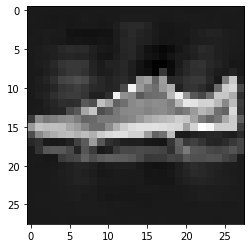

In [17]:
plt.imshow(adversarial_img[0,0],cmap='gray')

In [ ]:
pred_input = model(input_tensor)
pred_prob_input = F.softmax(pred_input, dim=1)
print('prediction of adversarial sample: {} with probability: {}'
      .format(torch.argmax(pred_prob_input),torch.max(pred_prob_input)))

In [ ]:
pred_prob_adv = F.softmax(pred_adv, dim=1)
print('prediction of adversarial sample: {} with probability: {}'.
      format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))


In [ ]:
target_onehot_ar = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
target_onehot = torch.from_numpy(target_onehot_ar)
target_onehot = target_onehot.cuda()

output_ar = np.array([[-5.3372, -5.6212, -4.7658, -3.9166, -2.1613, -3.9361, -6.2410, -2.7965,-2.5990, -0.3694]])
output = torch.from_numpy(output_ar)
output = output.cuda()


In [ ]:
target_onehot

In [ ]:
output

In [ ]:
(target_onehot * output).sum(1)

In [ ]:
real = (target_onehot * output).sum(1)
real

In [ ]:
other = ((1. - target_onehot) * output - target_onehot * 10000.)
other

In [ ]:
other = (other).max(1)[0]
other

In [ ]:
other - real

In [ ]:
torch.clamp(other - real, min=0.)

In [ ]:
# target_onehot:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
# Batch:   0, search step: 0
# output:  tensor([[-5.3372, -5.6212, -4.7658, -3.9166, -2.1613, -3.9361, -6.2410, -2.7965,
#          -2.5990, -0.3694]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
real:  tensor([-5.3372], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([-0.3694], device='cuda:0', grad_fn=<MaxBackward0>)


In [ ]:
real = (target * output).sum(1)
other = ((1. - target) * output - target * 10000.).max(1)[0]
        